In [21]:
# import library
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() 
import warnings 
warnings.filterwarnings('ignore')
import lightgbm as lgb 
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV
import csv
import glob

import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [22]:
# データの読み込み
train = pd.read_csv("/Users/tkhro1024/Desktop/theroom/d_bukken_train.csv")
test = pd.read_csv("/Users/tkhro1024/Desktop/theroom/d_bukken_test.csv")

In [23]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      345 non-null    int64  
 1   price_per_tsubo         345 non-null    int64  
 2   use_classification      345 non-null    object 
 3   minute_to_station       345 non-null    int64  
 4   land_space              345 non-null    int64  
 5   land_shape              345 non-null    object 
 6   frontage_length         345 non-null    float64
 7   frontal_road_direction  345 non-null    object 
 8   frontal_road_kind       345 non-null    object 
 9   frontal_road_width      345 non-null    float64
 10  building_land_ratio     345 non-null    int64  
 11  floor_land_ratio        345 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 32.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (tota

In [4]:
print(train.columns.values)

['id' 'price_per_tsubo' 'use_classification' 'minute_to_station'
 'land_space' 'land_shape' 'frontage_length' 'frontal_road_direction'
 'frontal_road_kind' 'frontal_road_width' 'building_land_ratio'
 'floor_land_ratio']


In [5]:
# 説明変数
X = pd.get_dummies(train[['minute_to_station',
 'land_space', 'land_shape', 'frontage_length', 'frontal_road_direction',
 'frontal_road_kind', 'frontal_road_width', 'building_land_ratio',
 'floor_land_ratio']]) 
# 目的変数
y = train['price_per_tsubo'] 

In [6]:
X.dtypes

minute_to_station              int64
land_space                     int64
frontage_length              float64
frontal_road_width           float64
building_land_ratio            int64
floor_land_ratio               int64
land_shape_ほぼ台形                uint8
land_shape_ほぼ整形                uint8
land_shape_ほぼ正方形               uint8
land_shape_ほぼ長方形               uint8
land_shape_不整形                 uint8
land_shape_台形                  uint8
land_shape_正方形                 uint8
land_shape_袋地等                 uint8
land_shape_長方形                 uint8
frontal_road_direction_北       uint8
frontal_road_direction_北東      uint8
frontal_road_direction_北西      uint8
frontal_road_direction_南       uint8
frontal_road_direction_南東      uint8
frontal_road_direction_南西      uint8
frontal_road_direction_東       uint8
frontal_road_direction_西       uint8
frontal_road_kind_区画街路         uint8
frontal_road_kind_国道           uint8
frontal_road_kind_市道           uint8
frontal_road_kind_町道           uint8
f

In [7]:
#データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
# モデルのインスタンスの作成
model = lgb.LGBMRegressor() 
 # モデルの学習
model.fit(X_train, y_train)
# テストデータの予測
y_pred = model.predict(X_test)

,elements,tsubo_tanka
142,240000,309427.353700
6,85000,156191.688930
60,550000,262246.709404
339,530000,650816.382966
54,240000,246212.155582


Text(0.5, 1.0, 'y vs y_pred')

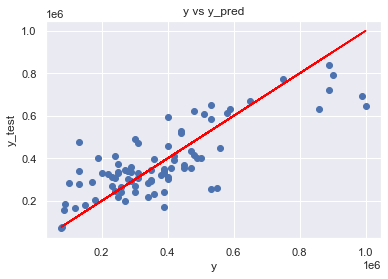

In [9]:
df_pred = pd.DataFrame({'elements':y_test,'tsubo_tanka':y_pred})
display(df_pred)

# 散布図を描画(真値 vs 予測値)
plt.plot(y_test, y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_test, y_pred) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_test') # y軸ラベル
plt.title('y vs y_pred') # グラフタイトル

In [10]:
# モデル評価
# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) # RSME = √MSEの算出
print('RMSE :',rmse)

# r2 : 決定係数
r2 = r2_score(y_test,y_pred)
print('R2 :',r2)

RMSE : 121055.1256168233
R2 : 0.6398415449440844


In [11]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

In [12]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l2', # 目的 : 回帰  
        'metric': {'rmse'}, # 評価指標 : rsme(平均二乗誤差の平方根) 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 258, number of used features: 19
[LightGBM] [Info] Start training from score 390081.395349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 189528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 178820
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 170037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 163074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 157223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 152055
[LightGBM] [Warning] No further splits wi

In [13]:
# 特徴量重要度の算出
f_importance = np.array(model.feature_importance()) 
# 正規化
f_importance = f_importance / np.sum(f_importance)

df_importance = pd.DataFrame({'feature':X, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
1,"(l, a, n, d, _, s, p, a, c, e)",0.278523
2,"(f, r, o, n, t, a, g, e, _, l, e, n, g, t, h)",0.202461
0,"(m, i, n, u, t, e, _, t, o, _, s, t, a, t, i, ...",0.165548
3,"(f, r, o, n, t, a, l, _, r, o, a, d, _, w, i, ...",0.139821
25,"(f, r, o, n, t, a, l, _, r, o, a, d, _, k, i, ...",0.035794


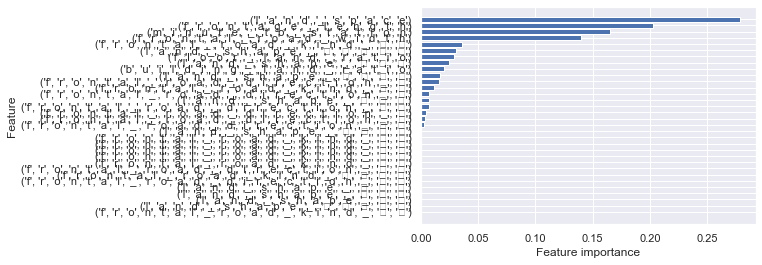

In [14]:
plot_feature_importance(df_importance)

In [15]:
# 特徴量重要度の算出 (データフレームで取得)
cols = X     

# 特徴量重要度の算出方法 'gain'(推奨) : トレーニングデータの損失の減少量を評価
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出 //
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
0,"(m, i, n, u, t, e, _, t, o, _, s, t, a, t, i, ...",0.701399
1,"(l, a, n, d, _, s, p, a, c, e)",0.104614
2,"(f, r, o, n, t, a, g, e, _, l, e, n, g, t, h)",0.059991
3,"(f, r, o, n, t, a, l, _, r, o, a, d, _, w, i, ...",0.057759
5,"(f, l, o, o, r, _, l, a, n, d, _, r, a, t, i, o)",0.028430


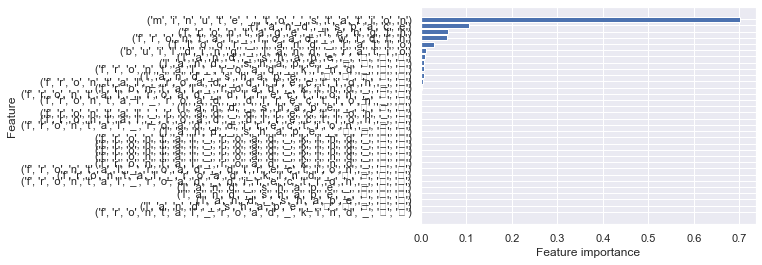

In [16]:
plot_feature_importance(df_importance)

142    240000
6       85000
60     550000
339    530000
54     240000
        ...  
12     260000
106    350000
141    230000
279    380000
17     410000
Name: price_per_tsubo, Length: 87, dtype: int64